[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/sub-graph.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239937-lesson-2-sub-graphs)

# Sub-graphs

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

We just covered parallelization, which is one important LangGraph controllability topic.

## Goals

Now, we're [going to cover sub-graphs](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#simple-example).

## State

Sub-graphs allow you to create and manage different states in different parts of your graph. 

This is particularly useful for multi-agent systems, with teams of agents that each have their own state.

Let's consider a John Mayer concert review analysis example:

* I have a system that accepts concert reviews from fans
* It performs two separate sub-tasks by different agents (analyze negative reviews, summarize positive feedback)
* I want to perform these two operations in two different sub-graphs.

The most critical thing to understand is how the graphs communicate! 

In short, communication is **done with over-lapping keys**: 

* The sub-graphs can access `reviews` from the parent
* The parent can access `negative_analysis/positive_summary` from the sub-graphs

![subgraph.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb1abf89f2d847ee6f1ff_sub-graph1.png)

## Input

Let's define a schema for the concert reviews that will be input to our graph.

In [ ]:
%%capture --no-stderr
%pip install -U  langgraph

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [2]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# The structure of concert reviews
class ConcertReview(TypedDict):
    id: str
    concert_date: str
    venue: str
    review_text: str
    rating: Optional[int]
    reviewer_type: Optional[str]
    issues: Optional[str]

## Sub graphs

Here is the negative review analysis sub-graph, which uses `NegativeReviewAnalysisState`.

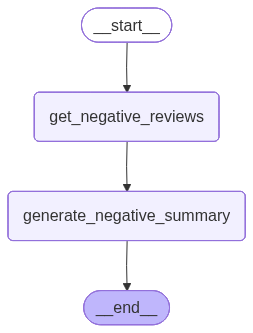

In [3]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Negative Review Analysis Sub-graph
class NegativeReviewAnalysisState(TypedDict):
    cleaned_reviews: List[ConcertReview]
    negative_reviews: List[ConcertReview]
    negative_analysis: str
    processed_reviews: List[str]

class NegativeReviewAnalysisOutputState(TypedDict):
    negative_analysis: str
    processed_reviews: List[str]

def get_negative_reviews(state):
    """ Get reviews that contain negative ratings """
    cleaned_reviews = state["cleaned_reviews"]
    negative_reviews = [review for review in cleaned_reviews if "rating" in review and review["rating"] <= 2]
    return {"negative_reviews": negative_reviews}

def generate_negative_summary(state):
    """ Generate summary of negative concert reviews """
    negative_reviews = state["negative_reviews"]
    # Add fxn: negative_analysis = summarize(negative_reviews)
    negative_analysis = "Sound quality issues reported during 'Gravity' performance at Madison Square Garden."
    return {"negative_analysis": negative_analysis, "processed_reviews": [f"negative-analysis-on-review-{review['id']}" for review in negative_reviews]}

na_builder = StateGraph(state_schema=NegativeReviewAnalysisState, output_schema=NegativeReviewAnalysisOutputState)
na_builder.add_node("get_negative_reviews", get_negative_reviews)
na_builder.add_node("generate_negative_summary", generate_negative_summary)
na_builder.add_edge(START, "get_negative_reviews")
na_builder.add_edge("get_negative_reviews", "generate_negative_summary")
na_builder.add_edge("generate_negative_summary", END)

graph = na_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Here is the positive feedback summarization sub-graph, which uses `PositiveFeedbackState`.

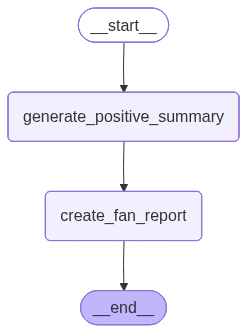

In [4]:
# Positive Feedback Summarization subgraph
class PositiveFeedbackState(TypedDict):
    cleaned_reviews: List[ConcertReview]
    positive_summary: str
    fan_report: str
    processed_reviews: List[str]

class PositiveFeedbackOutputState(TypedDict):
    fan_report: str
    processed_reviews: List[str]

def generate_positive_summary(state):
    cleaned_reviews = state["cleaned_reviews"]
    # Add fxn: summary = summarize(cleaned_reviews)
    summary = "Fans praised the extended guitar solo in 'Slow Dancing in a Burning Room' and the acoustic rendition of 'Neon'."
    return {"positive_summary": summary, "processed_reviews": [f"positive-summary-on-review-{review['id']}" for review in cleaned_reviews]}

def create_fan_report(state):
    positive_summary = state["positive_summary"]
    # Add fxn: fan_report = report_generation(positive_summary)
    fan_report = "Overall concert rating: 4.8/5 stars. Highlights: Extended solos, intimate acoustic set."
    return {"fan_report": fan_report}

pf_builder = StateGraph(PositiveFeedbackState, output_schema=PositiveFeedbackOutputState)
pf_builder.add_node("generate_positive_summary", generate_positive_summary)
pf_builder.add_node("create_fan_report", create_fan_report)
pf_builder.add_edge(START, "generate_positive_summary")
pf_builder.add_edge("generate_positive_summary", "create_fan_report")
pf_builder.add_edge("create_fan_report", END)

graph = pf_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Adding sub graphs to our parent graph

Now, we can bring it all together.

We create our parent graph with `EntryGraphState`. 

And we add our sub-graphs as nodes! 

```
entry_builder.add_node("positive_feedback", pf_builder.compile())
entry_builder.add_node("negative_analysis", na_builder.compile())
```

In [5]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_reviews: List[ConcertReview]
    cleaned_reviews: Annotated[List[ConcertReview], add] # This will be USED BY in BOTH sub-graphs
    negative_analysis: str # This will only be generated in the negative analysis sub-graph
    fan_report: str # This will only be generated in the positive feedback sub-graph
    processed_reviews: Annotated[List[int], add] # This will be generated in BOTH sub-graphs

But, why does `cleaned_reviews` have a reducer if it only goes *into* each sub-graph as an input? It is not modified.

```
cleaned_reviews: Annotated[List[ConcertReview], add] # This will be USED BY in BOTH sub-graphs
```

This is because the output state of the subgraphs will contain **all keys**, even if they are unmodified. 

The sub-graphs are run in parallel.

Because the parallel sub-graphs return the same key, it needs to have a reducer like `operator.add` to combine the incoming values from each sub-graph.

But, we can work around this by using another concept we talked about before.

We can simply create an output state schema for each sub-graph and ensure that the output state schema contains different keys to publish as output.

We don't actually need each sub-graph to output `cleaned_reviews`.

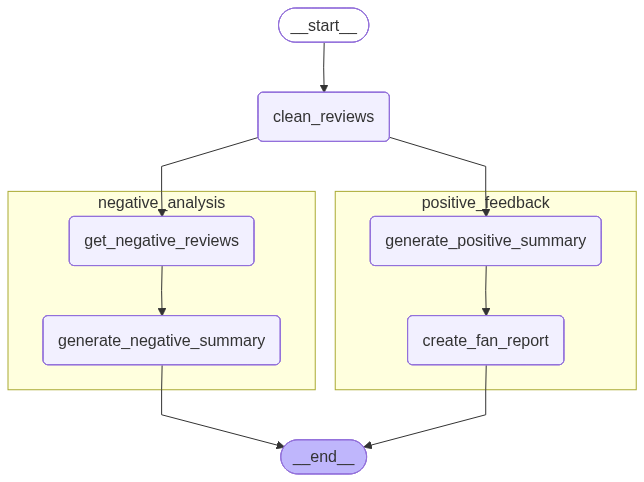

In [6]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_reviews: List[ConcertReview]
    cleaned_reviews: List[ConcertReview]
    negative_analysis: str # This will only be generated in the negative analysis sub-graph
    fan_report: str # This will only be generated in the positive feedback sub-graph
    processed_reviews: Annotated[List[int], add] # This will be generated in BOTH sub-graphs

def clean_reviews(state):
    # Get reviews
    raw_reviews = state["raw_reviews"]
    # Data cleaning raw_reviews -> cleaned_reviews
    cleaned_reviews = raw_reviews
    return {"cleaned_reviews": cleaned_reviews}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_reviews", clean_reviews)
entry_builder.add_node("positive_feedback", pf_builder.compile())
entry_builder.add_node("negative_analysis", na_builder.compile())

entry_builder.add_edge(START, "clean_reviews")
entry_builder.add_edge("clean_reviews", "negative_analysis")
entry_builder.add_edge("clean_reviews", "positive_feedback")
entry_builder.add_edge("negative_analysis", END)
entry_builder.add_edge("positive_feedback", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
# Dummy concert reviews
positive_review = ConcertReview(
    id="1",
    concert_date="2024-08-15",
    venue="Madison Square Garden",
    review_text="John Mayer's guitar work on 'Gravity' was absolutely stunning. The extended solo gave me chills!",
)

negative_review = ConcertReview(
    id="2",
    concert_date="2024-08-15",
    venue="Madison Square Garden",
    review_text="Sound quality was poor during the acoustic set. Could barely hear the vocals during 'Neon'.",
    rating=2,
    reviewer_type="Audio Quality Critic",
    issues="The audio mix was unbalanced, guitar overpowered vocals in the acoustic section",
)

raw_reviews = [positive_review, negative_review]
graph.invoke({"raw_reviews": raw_reviews})

{'raw_reviews': [{'id': '1',
   'concert_date': '2024-08-15',
   'venue': 'Madison Square Garden',
   'review_text': "John Mayer's guitar work on 'Gravity' was absolutely stunning. The extended solo gave me chills!"},
  {'id': '2',
   'concert_date': '2024-08-15',
   'venue': 'Madison Square Garden',
   'review_text': "Sound quality was poor during the acoustic set. Could barely hear the vocals during 'Neon'.",
   'rating': 2,
   'reviewer_type': 'Audio Quality Critic',
   'issues': 'The audio mix was unbalanced, guitar overpowered vocals in the acoustic section'}],
 'cleaned_reviews': [{'id': '1',
   'concert_date': '2024-08-15',
   'venue': 'Madison Square Garden',
   'review_text': "John Mayer's guitar work on 'Gravity' was absolutely stunning. The extended solo gave me chills!"},
  {'id': '2',
   'concert_date': '2024-08-15',
   'venue': 'Madison Square Garden',
   'review_text': "Sound quality was poor during the acoustic set. Could barely hear the vocals during 'Neon'.",
   'rati

## LangSmith

Let's look at the LangSmith trace:

https://smith.langchain.com/public/f8f86f61-1b30-48cf-b055-3734dfceadf2/r